# Assignment 3: KNN

<h2>Data splitting and pre-processing</h2>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import pickle
from tqdm import tqdm
import os
from collections import Counter



In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
project_data.isnull().sum()

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       3
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

In [4]:
#filling 3 null teacher prefix values with Teacher

project_data["teacher_prefix"].fillna("Teacher",inplace = True)
project_data.isnull().sum()

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       0
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

In [5]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [6]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [7]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109248 entries, 0 to 109247
Data columns (total 20 columns):
Unnamed: 0                                      109248 non-null int64
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109248 non-null object
school_state                                    109248 non-null object
project_submitted_datetime                      109248 non-null object
project_grade_category                          109248 non-null object
project_subject_categories                      109248 non-null object
project_subject_subcategories                   109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                       

**Considering only 50k train , 5k validation and 5k test data points**

In [8]:
from sklearn.utils import resample
p_d = resample(project_data,n_samples = 60000)

In [9]:
#splitting data as 30% to test
y = p_d["project_is_approved"]
X = p_d.drop("project_is_approved",axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [10]:
print(X_train.shape," ",y_train.shape)
print(X_test.shape," ",y_test.shape)
print(X_val.shape," ",y_val.shape)

(48600, 19)   (48600,)
(6000, 19)   (6000,)
(5400, 19)   (5400,)


<h3>Preprocessing categorical Features</h3>

1. project subject categories

In [11]:
#using code from assignment
# project subject categories
catogories = list(X_train['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_train['clean_categories'] = cat_list
X_train.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in X_train['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


# project subject categories for test data

catogories = list(X_test['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_test['clean_categories'] = cat_list
X_test.drop(['project_subject_categories'], axis=1, inplace=True)

# project subject categories for test data

catogories = list(X_val['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_val['clean_categories'] = cat_list
X_val.drop(['project_subject_categories'], axis=1, inplace=True)


2. project subject sub_categories

In [12]:
sub_catogories = list(X_train['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_train['clean_subcategories'] = sub_cat_list
X_train.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in X_train['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


sub_catogories = list(X_test['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_test['clean_subcategories'] = sub_cat_list
X_test.drop(['project_subject_subcategories'], axis=1, inplace=True)


# for validation data set
sub_catogories = list(X_val['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_val['clean_subcategories'] = sub_cat_list
X_val.drop(['project_subject_subcategories'], axis=1, inplace=True)

3. Teacher Prefix

In [13]:
#preprocessing teacher prefix
prefix = list(X_train['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_train['clean_prefix'] = prefix_list

my_counter = Counter()
for word in X_train['clean_prefix'].values:
  my_counter.update(word.split())

prefix_dict = dict(my_counter)
sorted_prefix_dict = dict(sorted(prefix_dict.items(), key=lambda kv: kv[1]))
print(sorted_prefix_dict)


#preprocessing teacher prefix for test data
prefix = list(X_test['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_test['clean_prefix'] = prefix_list

#preprocessing teacher prefix for val data
prefix = list(X_val['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_val['clean_prefix'] = prefix_list

{'Dr': 8, 'Teacher': 978, 'Mr': 4738, 'Ms': 17189, 'Mrs': 25687}


4. Project Grade Category

In [14]:
# preprocessing of grade category for train data

grade = list(X_train['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_train['clean_grade'] = grade_list

my_counter = Counter()
for word in X_train['clean_grade'].values:
  my_counter.update(word.split())

grade_dict = dict(my_counter)
sorted_grade_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))
print(sorted_grade_dict)

# preprocessing of grade category for test data

grade = list(X_test['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_test['clean_grade'] = grade_list


grade = list(X_val['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_val['clean_grade'] = grade_list


{'nine_twelve': 4771, 'six_eight': 7528, 'three_five': 16559, 'prek_two': 19742}


5. School State

In [15]:
#no need of preprocessing on school state

state = X_train["school_state"].value_counts()
sorted_state = dict(state)
sorted_state_dict = dict(sorted(sorted_state.items(), key=lambda kv: kv[1]))
X_train["clean_state"] = X_train["school_state"]

#similarly for X_test
X_test["clean_state"] = X_test["school_state"]

#similarly for X_val
X_val["clean_state"] = X_val["school_state"]

<h3>Preprocessing Numerical Feature</h3>

1. Standardizing price

In [16]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) 
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

#train data price standardization
price_standardized = price_scalar.transform(X_train['price'].values.reshape(-1, 1))

#val data price stanardization. Fit method applied on X_train
val_price_standardized = price_scalar.transform(X_val['price'].values.reshape(-1, 1))


#test data price stanardization. Fit method applied on X_train
test_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


2. Standardizing quantity

In [17]:
price_scalar = StandardScaler()
price_scalar.fit(X_train["quantity"].values.reshape(-1, 1))
print(f"Mean of Quantity : {price_scalar.mean_[0]}, Standard deviation of Quantity : {np.sqrt(price_scalar.var_[0])}")

#train data quantity standardization
quantity_standardized = price_scalar.transform(X_train["quantity"].values.reshape(-1, 1))

#val data quantity stanardization. Fit method applied on X_train
val_quantity_standardized = price_scalar.transform(X_val["quantity"].values.reshape(-1, 1))

#test data quantity stanardization. Fit method applied on X_train
test_quantity_standardized = price_scalar.transform(X_test["quantity"].values.reshape(-1, 1))

C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Mean of Quantity : 17.133827160493826, Standard deviation of Quantity : 27.176613943520394


C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


3. Standardizing number of ppp

In [18]:
price_scalar = StandardScaler()
price_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

#train data ppp standardization
number_ppp_standardized = price_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

#val data price stanardization. Fit method applied on X_train
val_number_ppp_standardized = price_scalar.transform(X_val['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

#test data price stanardization. Fit method applied on X_train
test_number_ppp_standardized = price_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Mean : 10.912674897119341, Standard deviation : 27.00797755650471


C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<h3>Preprocessing of Text Feature for both test and train data</h3>

In [19]:
#using function and stopwords form assignemnt

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
  
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

1. preprocessing of project essay

In [20]:
from tqdm import tqdm

#for train data
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
    
val_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_val['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    val_preprocessed_essays.append(sent.lower().strip())

    
    
test_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    test_preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1576.18it/s]


2. preprocessing of project title

In [21]:
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())
    
# for val data
val_preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_val['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    val_preprocessed_title.append(sent.lower().strip())
    
    
# for test data
test_preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    test_preprocessed_title.append(sent.lower().strip())


100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 36119.34it/s]


<h3>Vectorizing of Categorical data</h3>

1. Vectorizing project categories and subcategories

In [22]:
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())
categories_feature = vectorizer.get_feature_names()

# for train data
categories_one_hot = vectorizer.transform(X_train['clean_categories'].values)

print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

# for val data
val_categories_one_hot = vectorizer.transform(X_val['clean_categories'].values)


# for test data
test_categories_one_hot = vectorizer.transform(X_test['clean_categories'].values)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'Health_Sports', 'SpecialNeeds', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (48600, 9)


2. Vectorizing project subcategories

In [23]:
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())
subcategories_feature = vectorizer.get_feature_names()

# for train data
sub_categories_one_hot = vectorizer.transform(X_train['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

# for val data
val_sub_categories_one_hot = vectorizer.transform(X_val['clean_subcategories'].values)


# for test data
test_sub_categories_one_hot = vectorizer.transform(X_test['clean_subcategories'].values)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Civics_Government', 'Extracurricular', 'ForeignLanguages', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'PerformingArts', 'SocialSciences', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'Gym_Fitness', 'ESL', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (48600, 30)


3. vectorizing teacher prefix

In [24]:
vectorizer = CountVectorizer(vocabulary=list(prefix_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_prefix'].values)
print(vectorizer.get_feature_names())
prefix_feature = vectorizer.get_feature_names()
# for train data
prefix_one_hot = vectorizer.transform(X_train['clean_prefix'].values)
print("Shape of matrix after one hot encodig ",prefix_one_hot.shape)

# for val data
val_prefix_one_hot = vectorizer.transform(X_val['clean_prefix'].values)


# for test data
test_prefix_one_hot = vectorizer.transform(X_test['clean_prefix'].values)

['Mr', 'Mrs', 'Ms', 'Teacher', 'Dr']
Shape of matrix after one hot encodig  (48600, 5)


4. Vectorizing school state and grade

In [25]:
vectorizer = CountVectorizer(vocabulary=list(grade_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_grade'].values)
print(vectorizer.get_feature_names())
grade_feature = vectorizer.get_feature_names()
# for train data
grade_one_hot = vectorizer.transform(X_train['clean_grade'].values)
print("Shape of matrix after one hot encodig ",grade_one_hot.shape)

# for val data
val_grade_one_hot = vectorizer.transform(X_val['clean_grade'].values)

# for test data
test_grade_one_hot = vectorizer.transform(X_test['clean_grade'].values)


vectorizer = CountVectorizer(vocabulary=list(sorted_state_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_state'].values)
print(vectorizer.get_feature_names())
state_one_hot = vectorizer.transform(X_train['clean_state'].values)
state_feature = vectorizer.get_feature_names()

val_state_one_hot = vectorizer.transform(X_val['clean_state'].values)

test_state_one_hot = vectorizer.transform(X_test['clean_state'].values)



['nine_twelve', 'prek_two', 'six_eight', 'three_five']
Shape of matrix after one hot encodig  (48600, 4)
['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'AK', 'DE', 'NE', 'NH', 'HI', 'WV', 'DC', 'ME', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'MD', 'NV', 'CT', 'UT', 'TN', 'AL', 'WI', 'VA', 'NJ', 'AZ', 'WA', 'LA', 'MA', 'OK', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']


<h3>Vectorizing Text Feature</h3>

1. BOW

In [26]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
#fit using train data
vectorizer.fit(preprocessed_essays)
essay_feature = vectorizer.get_feature_names()


# for train data
text_bow = vectorizer.transform(preprocessed_essays)
print("Shape of train matrix : ",text_bow.shape)

# for val data
val_text_bow = vectorizer.transform(val_preprocessed_essays)


# for test data
test_text_bow = vectorizer.transform(test_preprocessed_essays)
print("Shape of test matrix : ",test_text_bow.shape)


# for title
vectorizer.fit(preprocessed_title)
title_feature = vectorizer.get_feature_names()

# for train data
title_bow = vectorizer.transform(preprocessed_title)
print("Shape of train matrix : ",title_bow.shape)

# for val data
val_title_bow = vectorizer.transform(val_preprocessed_title)
print("Shape of test matrix : ",val_title_bow.shape)

# for test data
test_title_bow = vectorizer.transform(test_preprocessed_title)
print("Shape of test matrix : ",test_title_bow.shape)

Shape of train matrix :  (48600, 5000)
Shape of test matrix :  (6000, 5000)
Shape of train matrix :  (48600, 4190)
Shape of test matrix :  (5400, 4190)
Shape of test matrix :  (6000, 4190)


2. TFIDF

In [27]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
#fit using train data
vectorizer.fit(preprocessed_essays)
essay_feature_tfidf = vectorizer.get_feature_names()
# for train data
text_tfidf = vectorizer.transform(preprocessed_essays)
print("Shape of train matrix : ",text_tfidf.shape)


# for val data
val_text_tfidf = vectorizer.transform(val_preprocessed_essays)
print("Shape of val matrix : ",val_text_tfidf.shape)

# for test data
test_text_tfidf = vectorizer.transform(test_preprocessed_essays)
print("Shape of test matrix : ",test_text_tfidf.shape)


# for title
vectorizer.fit(preprocessed_title)
title_feature_tfidf = vectorizer.get_feature_names()

# for train data
title_tfidf = vectorizer.transform(preprocessed_title)
print("Shape of train matrix : ",title_tfidf.shape)

# for val data
val_title_tfidf = vectorizer.transform(val_preprocessed_title)
print("Shape of val matrix : ",val_title_tfidf.shape)


# for test data
test_title_tfidf = vectorizer.transform(test_preprocessed_title)
print("Shape of test matrix : ",test_title_tfidf.shape)

Shape of train matrix :  (48600, 5000)
Shape of val matrix :  (5400, 5000)
Shape of test matrix :  (6000, 5000)
Shape of train matrix :  (48600, 4190)
Shape of val matrix :  (5400, 4190)
Shape of test matrix :  (6000, 4190)


3. Avg W2v

In [28]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [29]:
# for train data
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)
print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))


# for val data
val_avg_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(val_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    val_avg_w2v_vectors.append(vector)

print(len(val_avg_w2v_vectors))
print(len(val_avg_w2v_vectors[0]))

    
# for test data
test_avg_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_avg_w2v_vectors.append(vector)

print(len(test_avg_w2v_vectors))
print(len(test_avg_w2v_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████| 48600/48600 [00:15<00:00, 3103.63it/s]


48600
300


100%|████████████████████████████████████████████████████████████████████████████| 5400/5400 [00:01<00:00, 3117.68it/s]


5400
300


100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:01<00:00, 3046.82it/s]


6000
300


In [30]:
title_avg_w2v_vectors = []
for sentence in tqdm(preprocessed_title): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_avg_w2v_vectors.append(vector)

print(len(title_avg_w2v_vectors))
print(len(title_avg_w2v_vectors[0]))

# for val data
val_title_avg_w2v_vectors = []
for sentence in tqdm(val_preprocessed_title): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    val_title_avg_w2v_vectors.append(vector)

print(len(val_title_avg_w2v_vectors))
print(len(val_title_avg_w2v_vectors[0]))


# for test data
test_title_avg_w2v_vectors = []
for sentence in tqdm(test_preprocessed_title): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_title_avg_w2v_vectors.append(vector)

print(len(test_title_avg_w2v_vectors))
print(len(test_title_avg_w2v_vectors[0]))


100%|█████████████████████████████████████████████████████████████████████████| 48600/48600 [00:00<00:00, 61269.86it/s]


48600
300


100%|███████████████████████████████████████████████████████████████████████████| 5400/5400 [00:00<00:00, 59946.06it/s]


5400
300


100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 59946.32it/s]


6000
300


4. TFIDF avgw2v

In [31]:
#  for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

# -------------- for val data --------------------------
val_tfidf_model = TfidfVectorizer()
val_tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(val_tfidf_model.get_feature_names(), list(val_tfidf_model.idf_)))
tfidf_words = set(val_tfidf_model.get_feature_names())

val_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(val_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    val_tfidf_w2v_vectors.append(vector)

print(len(val_tfidf_w2v_vectors))
print(len(val_tfidf_w2v_vectors[0]))




# ------------------ for test data ---------------------------
test_tfidf_model = TfidfVectorizer()
test_tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(test_tfidf_model.get_feature_names(), list(test_tfidf_model.idf_)))
tfidf_words = set(test_tfidf_model.get_feature_names())

test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_vectors.append(vector)

print(len(test_tfidf_w2v_vectors))
print(len(test_tfidf_w2v_vectors[0]))


100%|███████████████████████████████████████████████████████████████████████████| 48600/48600 [01:48<00:00, 449.76it/s]


48600
300


100%|█████████████████████████████████████████████████████████████████████████████| 5400/5400 [00:12<00:00, 424.20it/s]


5400
300


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:13<00:00, 441.12it/s]


6000
300


In [32]:
# for title 
tfidf_model.fit(preprocessed_title)

dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_tfidf_w2v_vectors.append(vector)

print(len(title_tfidf_w2v_vectors))

# -------------- for val title -----------------------------
val_tfidf_model.fit(preprocessed_title)

dictionary = dict(zip(val_tfidf_model.get_feature_names(), list(val_tfidf_model.idf_)))
tfidf_words = set(val_tfidf_model.get_feature_names())


val_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(val_preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    val_title_tfidf_w2v_vectors.append(vector)

print(len(val_title_tfidf_w2v_vectors))



# --------------- for test title  ----------------------
test_tfidf_model.fit(preprocessed_title)

dictionary = dict(zip(test_tfidf_model.get_feature_names(), list(test_tfidf_model.idf_)))
tfidf_words = set(test_tfidf_model.get_feature_names())


test_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_title_tfidf_w2v_vectors.append(vector)

print(len(test_title_tfidf_w2v_vectors))


100%|█████████████████████████████████████████████████████████████████████████| 48600/48600 [00:01<00:00, 30644.57it/s]


48600


100%|███████████████████████████████████████████████████████████████████████████| 5400/5400 [00:00<00:00, 29084.43it/s]


5400


100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 31886.35it/s]


6000


Printing all

In [33]:
print("*"*70)
print("Categorical Features that are considered :- ")
print("Subject Categories :- ",categories_one_hot.shape)
print("Subject Sub-Categories :- ",sub_categories_one_hot.shape)
print("Sudent Grade :- ",grade_one_hot.shape)
print("School State :- ",state_one_hot.shape)
print("Teacher Prefix :- ",prefix_one_hot.shape)
print("*"*70)

**********************************************************************
Categorical Features that are considered :- 
Subject Categories :-  (48600, 9)
Subject Sub-Categories :-  (48600, 30)
Sudent Grade :-  (48600, 4)
School State :-  (48600, 51)
Teacher Prefix :-  (48600, 5)
**********************************************************************


In [34]:
print("Text Features that are considered :- ")
print("*"*70)
print("Project Essay BOW:- ",text_bow.shape)
print("Project Essay TFIDF:- ",text_tfidf.shape)
print("*"*70)
print("Project Title BOW:- ",title_bow.shape)
print("Project Title TFIDF:- ",title_tfidf.shape)
print("*"*70)

Text Features that are considered :- 
**********************************************************************
Project Essay BOW:-  (48600, 5000)
Project Essay TFIDF:-  (48600, 5000)
**********************************************************************
Project Title BOW:-  (48600, 4190)
Project Title TFIDF:-  (48600, 4190)
**********************************************************************


# sets

In [35]:
#combining all feature into one
from scipy.sparse import hstack

set1 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,grade_one_hot,state_one_hot,price_standardized,quantity_standardized,number_ppp_standardized,text_bow,title_bow))
set1_v = hstack((val_categories_one_hot,val_sub_categories_one_hot,val_prefix_one_hot,val_grade_one_hot,val_state_one_hot,val_price_standardized,val_quantity_standardized,val_number_ppp_standardized,val_text_bow,val_title_bow))
set1_t = hstack((test_categories_one_hot,test_sub_categories_one_hot,test_prefix_one_hot,test_grade_one_hot,test_state_one_hot,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized,test_text_bow,test_title_bow))

set2 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,state_one_hot,grade_one_hot,text_tfidf,title_tfidf,price_standardized,quantity_standardized,number_ppp_standardized))
set2_v = hstack((val_categories_one_hot,val_sub_categories_one_hot,val_prefix_one_hot,val_state_one_hot,val_grade_one_hot,val_text_tfidf,val_title_tfidf,val_price_standardized,val_quantity_standardized,val_number_ppp_standardized))
set2_t = hstack((test_categories_one_hot,test_sub_categories_one_hot,test_prefix_one_hot,test_state_one_hot,test_grade_one_hot,test_text_tfidf,test_title_tfidf,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized))

set3 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,state_one_hot,grade_one_hot,price_standardized,quantity_standardized,number_ppp_standardized,avg_w2v_vectors,title_avg_w2v_vectors))
set3_v = hstack((val_categories_one_hot,val_sub_categories_one_hot,val_prefix_one_hot,val_state_one_hot,val_grade_one_hot,val_price_standardized,val_quantity_standardized,val_number_ppp_standardized,val_avg_w2v_vectors,val_title_avg_w2v_vectors))
set3_t = hstack((test_categories_one_hot,test_sub_categories_one_hot,test_prefix_one_hot,test_state_one_hot,test_grade_one_hot,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized,test_avg_w2v_vectors,test_title_avg_w2v_vectors))

set4 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,state_one_hot,grade_one_hot,price_standardized,quantity_standardized,number_ppp_standardized,tfidf_w2v_vectors,title_tfidf_w2v_vectors))
set4_v = hstack((val_categories_one_hot,val_sub_categories_one_hot,val_prefix_one_hot,val_state_one_hot,val_grade_one_hot,val_price_standardized,val_quantity_standardized,val_number_ppp_standardized,val_tfidf_w2v_vectors,val_title_tfidf_w2v_vectors))
set4_t = hstack((test_categories_one_hot,test_sub_categories_one_hot,test_prefix_one_hot,test_state_one_hot,test_grade_one_hot,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized,test_tfidf_w2v_vectors,test_title_tfidf_w2v_vectors))


print(set1.shape,"\t",set1_t.shape,"\t",set1_v.shape)
print(set2.shape,"\t",set2_t.shape,"\t",set2_v.shape)
print(set3.shape,"\t",set3_t.shape,"\t",set3_v.shape)
print(set4.shape,"\t",set4_t.shape,"\t",set4_v.shape)

(48600, 9292) 	 (6000, 9292) 	 (5400, 9292)
(48600, 9292) 	 (6000, 9292) 	 (5400, 9292)
(48600, 702) 	 (6000, 702) 	 (5400, 702)
(48600, 702) 	 (6000, 702) 	 (5400, 702)


In [36]:
set_feature = categories_feature + subcategories_feature + prefix_feature +state_feature +  grade_feature + essay_feature_tfidf + title_feature_tfidf


set_feature.append("price")
set_feature.append("quantity")
set_feature.append("number")
print(len(set_feature))

9292


In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

## SET1 (BOW)

Completed for k  = 5
Completed for k  = 15
Completed for k  = 21
Completed for k  = 31
Completed for k  = 41
Completed for k  = 51


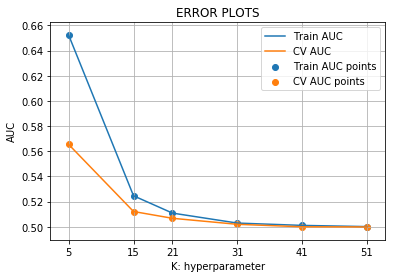

In [38]:
train_auc = []
cv_auc = []
K = [5, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(set1,y_train)
    
    y_train_pred = neigh.predict(set1)  
    y_cv_pred = neigh.predict(set1_v)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed for k  = {}".format(i))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.xticks(K)
plt.grid()
plt.show()

**AUC plot**

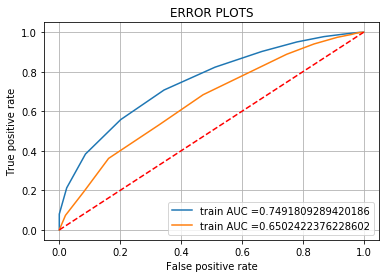

In [45]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(set1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = neigh.predict_proba(set1)[:,1]
y_test_pred = neigh.predict_proba(set1_t)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr,label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix')

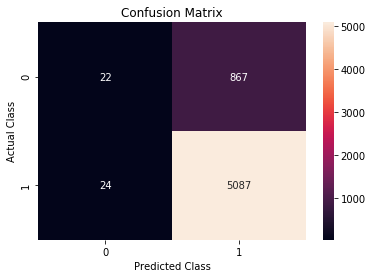

In [46]:
y_test_pred = neigh.predict(set1_t)
cm1 = confusion_matrix(y_test,y_test_pred)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm1, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

## Set2 (TFIDF)

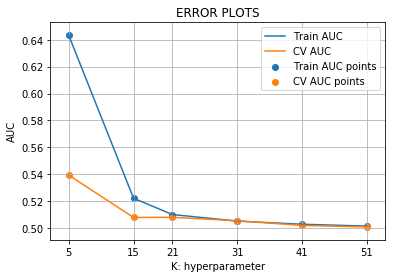

In [49]:
train_auc = []
cv_auc = []
K = [5, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(set2,y_train)
    
    y_train_pred = neigh.predict(set2)  
    y_cv_pred = neigh.predict(set2_v)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed for k  = {}".format(i))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.xticks(K)
plt.grid()
plt.show()

**AUC Plot**

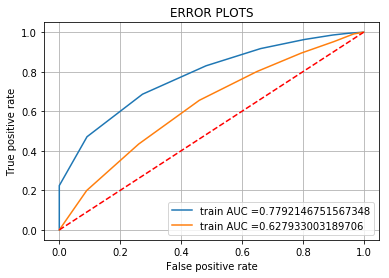

In [50]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(set2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = neigh.predict_proba(set2)[:,1]
y_test_pred = neigh.predict_proba(set2_t)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr,label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix')

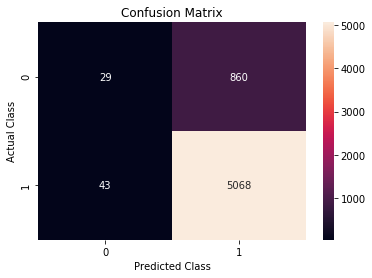

In [51]:
y_test_pred = neigh.predict(set2_t)
cm = confusion_matrix(y_test,y_test_pred)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

## Set3 (Avg W2V)

Completed for k  = 5
Completed for k  = 15
Completed for k  = 21
Completed for k  = 31
Completed for k  = 41
Completed for k  = 51


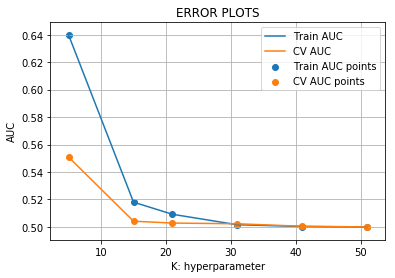

In [38]:
train_auc = []
cv_auc = []
K = [5, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(set3,y_train)
    
    y_train_pred = neigh.predict(set3)  
    y_cv_pred = neigh.predict(set3_v)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed for k  = {}".format(i))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**AUC plot**

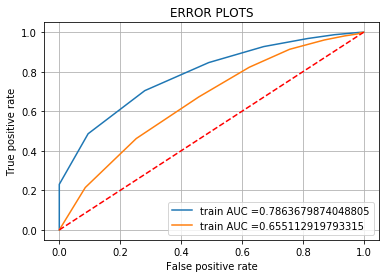

In [39]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(set3, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = neigh.predict_proba(set3)[:,1]
y_test_pred = neigh.predict_proba(set3_t)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr,label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**confusion matrix**

Text(0.5, 1.0, 'Confusion Matrix')

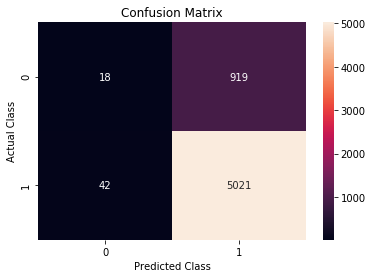

In [40]:
y_test_pred = neigh.predict(set3_t)
cm = confusion_matrix(y_test,y_test_pred)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

## Set4 (TFIDF Avg_w2v)

Completed for k  = 5
Completed for k  = 15
Completed for k  = 21
Completed for k  = 31
Completed for k  = 41
Completed for k  = 51


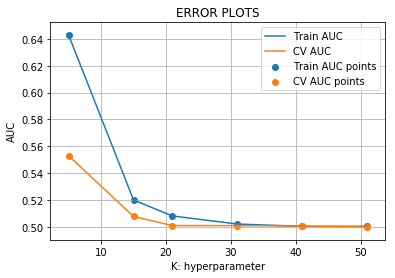

In [41]:
train_auc = []
cv_auc = []
K = [5, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(set4,y_train)
    
    y_train_pred = neigh.predict(set4)  
    y_cv_pred = neigh.predict(set4_v)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed for k  = {}".format(i))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**AUC plot**

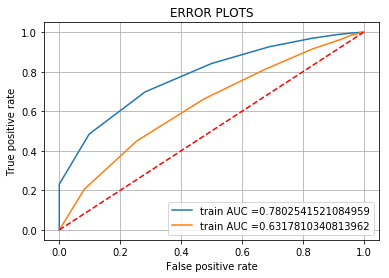

In [39]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(set4, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = neigh.predict_proba(set4)[:,1]
y_test_pred = neigh.predict_proba(set4_t)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr,label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix')

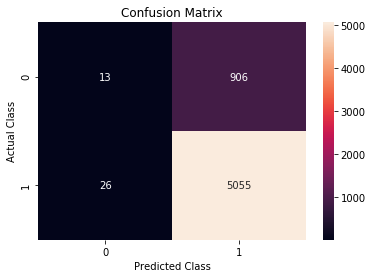

In [40]:
y_test_pred = neigh.predict(set4_t)
cm = confusion_matrix(y_test,y_test_pred)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

## Task-2

- Using selectBest to get **top 2k** features for Set2 i.e TFIDF

In [41]:
from sklearn.feature_selection import SelectKBest
sk = SelectKBest(k=2000).fit(set2, y_train)

set_ = sk.transform(set2)
set_t = sk.transform(set2_t)
set_v = sk.transform(set2_v)

In [42]:
print(set1.shape," ",set_.shape)

(48600, 9292)   (48600, 2000)


Completed for k  = 5
Completed for k  = 15
Completed for k  = 21
Completed for k  = 31
Completed for k  = 41
Completed for k  = 51


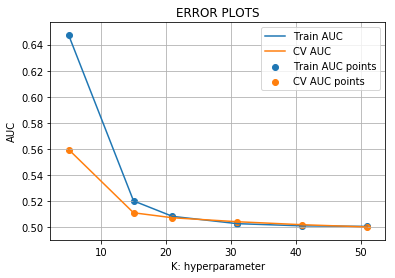

In [44]:
train_auc = []
cv_auc = []
K = [5, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(set_,y_train)
    
    y_train_pred = neigh.predict(set_)  
    y_cv_pred = neigh.predict(set_v)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed for k  = {}".format(i))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**AUC Plot**

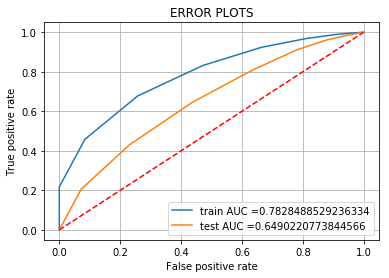

In [46]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(set_, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = neigh.predict_proba(set_)[:,1]
y_test_pred = neigh.predict_proba(set_t)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr,label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix')

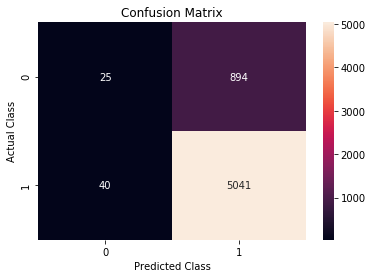

In [47]:
y_test_pred = neigh.predict(set_t)
cm = confusion_matrix(y_test,y_test_pred)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

### Observation
===================

1. Best Result found in case of Avg W2V
2. Best auc was found is 0.786 in case of Avg-W2V
3. Model performed worst in case of BOW
4. Performance of model improoved when number of data points increased.

### Summary

In [56]:
from prettytable import PrettyTable
summary = PrettyTable()

In [57]:
summary.field_names = ["Set", "Vectorizer", "Hyperparameter","Test","Train"]

In [58]:
summary.add_row(["set1","BOW","k = 15",0.65,0.74])
summary.add_row(["set2","TFIDF","k = 15",0.62,0.779])
summary.add_row(["set3","Avg-W2v","k = 15",0.655,0.786])
summary.add_row(["set4","TFIDF W2V","k = 15",0.63,0.78])
summary.add_row(["Task2 (set5)","TFIDF","k = 15",0.64,0.78])


In [59]:
print(summary)

+--------------+------------+----------------+-------+-------+
|     Set      | Vectorizer | Hyperparameter |  Test | Train |
+--------------+------------+----------------+-------+-------+
|     set1     |    BOW     |     k = 15     |  0.65 |  0.74 |
|     set2     |   TFIDF    |     k = 15     |  0.62 | 0.779 |
|     set3     |  Avg-W2v   |     k = 15     | 0.655 | 0.786 |
|     set4     | TFIDF W2V  |     k = 15     |  0.63 |  0.78 |
| Task2 (set5) |   TFIDF    |     k = 15     |  0.64 |  0.78 |
+--------------+------------+----------------+-------+-------+
